# Data Sources Overview

Quick look at each raw dataset pulled by the pipeline.
Fourteen datasets are currently collected:

1. **Fama-French SIC Codes** — industry classification ranges (Dartmouth/Kenneth French)
2. **FISD Amount Outstanding History** — historical par amount changes (WRDS)
3. **FISD Issue** — bond-level reference data (WRDS)
4. **FISD Issuer** — issuer-level reference data (WRDS)
5. **FISD Ratings (Moody's)** — Moody's bond ratings history (WRDS)
6. **FISD Ratings (S&P)** — S&P bond ratings history (WRDS)
7. **FISD Redemption** — callable/redemption flags (WRDS)
8. **Liu-Wu Treasury Yields** — zero-coupon yield curve (Google Sheets)
9. **OSBAP Corporate Bond Returns** — monthly bond returns; used for Stage 1 validation only (OpenBondAssetPricing.com)
10. **OSBAP Linker (Fang, 2025)** — bond-firm link mapping CUSIPs to PERMNO/PERMCO/GVKEY; core Stage 1 input (OpenBondAssetPricing.com)
11. **OSBAP Treasury Bond Returns** — treasury returns; currently documentation only (OpenBondAssetPricing.com)
12. **TRACE 144A** — Rule 144A private placement trades (WRDS)
13. **TRACE Enhanced** — trade-level transaction data (WRDS)
14. **TRACE Standard** — trade-level transaction data (WRDS)

In [1]:
from pathlib import Path

import polars as pl

from settings import config

DATA_DIR = Path(config("DATA_DIR"))
PULL_DIR = DATA_DIR / "pulled"

---
## 1. Fama-French SIC Codes — `pulled/ff17_sic_ranges.parquet` + `pulled/ff30_sic_ranges.parquet`

Source script: `pull_fama_french_sic.py` | Source: Kenneth French Data Library (Dartmouth)

Industry-to-SIC-code range mappings from the Fama-French 17- and 30-industry
classification systems. Each row maps an industry number and name to a
contiguous SIC code range. Used by Stage 1 for industry classification.

**Key columns:**

| Column | Description |
|---|---|
| `ind_num` | Industry number in the FF classification |
| `ind_name` | Short industry name |
| `sic_start` | Start of SIC code range |
| `sic_end` | End of SIC code range |

In [2]:
ff17 = pl.scan_parquet(PULL_DIR / "ff17_sic_ranges.parquet")
n_rows_ff17 = ff17.select(pl.len()).collect().item()
cols_ff17 = ff17.collect_schema().names()
print(f"FF17 — Rows: {n_rows_ff17:,}  |  Columns: {len(cols_ff17)}")
print(f"Column names: {cols_ff17}")

FF17 — Rows: 567  |  Columns: 4
Column names: ['ind_num', 'ind_name', 'sic_start', 'sic_end']


### Example rows — FF17

In [3]:
ff17.head(5).collect()

ind_num,ind_name,sic_start,sic_end
i64,str,i64,i64
1,"""Food""",100,199
1,"""Food""",200,299
1,"""Food""",700,799
1,"""Food""",900,999
1,"""Food""",2000,2009


In [4]:
ff30 = pl.scan_parquet(PULL_DIR / "ff30_sic_ranges.parquet")
n_rows_ff30 = ff30.select(pl.len()).collect().item()
cols_ff30 = ff30.collect_schema().names()
print(f"FF30 — Rows: {n_rows_ff30:,}  |  Columns: {len(cols_ff30)}")
print(f"Column names: {cols_ff30}")

FF30 — Rows: 587  |  Columns: 4
Column names: ['ind_num', 'ind_name', 'sic_start', 'sic_end']


### Example rows — FF30

In [5]:
ff30.head(5).collect()

ind_num,ind_name,sic_start,sic_end
i64,str,i64,i64
1,"""Food""",100,199
1,"""Food""",200,299
1,"""Food""",700,799
1,"""Food""",910,919
1,"""Food""",2000,2009


---
## 2. FISD Amount Outstanding History — `pulled/fisd_amt_out_hist.parquet`

Source script: `pull_fisd.py` | WRDS table: `fisd.fisd_amt_out_hist`

Historical changes in par amount outstanding for each bond issue.
Records actions such as increases, decreases, and maturities that
change the total amount of a bond outstanding over time.

In [6]:
amt_out = pl.scan_parquet(PULL_DIR / "fisd_amt_out_hist.parquet")
n_rows_amt = amt_out.select(pl.len()).collect().item()
cols_amt = amt_out.collect_schema().names()
print(f"Rows: {n_rows_amt:,}  |  Columns: {len(cols_amt)}")
print(f"Column names: {cols_amt}")

Rows: 862,582  |  Columns: 7
Column names: ['transaction_id', 'issue_id', 'action_type', 'effective_date', 'action_price', 'action_amount', 'amount_outstanding']


### Example rows

In [7]:
amt_out.head(5).collect()

transaction_id,issue_id,action_type,effective_date,action_price,action_amount,amount_outstanding
f64,f64,str,str,f64,f64,f64
1.0,1.0,"""IL""","""1994-05-31""",null,null,65000.0
58254.0,1.0,"""REV""","""1995-05-31""",null,null,65000.0
83800.0,1.0,"""REV""","""1996-05-31""",null,null,65000.0
129007.0,1.0,"""REV""","""1997-05-31""",null,null,65000.0
168464.0,1.0,"""REV""","""1998-05-31""",null,null,65000.0


---
## 3. FISD Issue Data — `pulled/fisd_issue.parquet`

Source script: `pull_fisd.py` | WRDS table: `fisd.fisd_mergedissue`

One row per fixed-income security (bond issue) in the Mergent FISD database.
Contains bond characteristics such as coupon, maturity, and offering details.

**Key columns:**

| Column | Description |
|---|---|
| `complete_cusip` | 9-character CUSIP identifier |
| `issue_name` | Descriptive name of the bond issue |
| `issuer_id` | Foreign key to the issuer table |
| `coupon` | Annual coupon rate (%) |
| `coupon_type` | Coupon type (F=fixed, V=variable, etc.) |
| `maturity` | Maturity date |
| `offering_date` | Original offering date |
| `bond_type` | Bond type code (CDEB, CMTN, etc.) |
| `offering_amt` | Offering amount ($ millions) |
| `principal_amt` | Par value per bond (typically 1000) |

In [8]:
fisd_issue = pl.scan_parquet(PULL_DIR / "fisd_issue.parquet")
n_rows = fisd_issue.select(pl.len()).collect().item()
cols = fisd_issue.collect_schema().names()
print(f"Rows: {n_rows:,}  |  Columns: {len(cols)}")
print(f"Column names: {cols}")

Rows: 710,098  |  Columns: 19
Column names: ['complete_cusip', 'issue_id', 'issue_name', 'issuer_id', 'foreign_currency', 'coupon_type', 'coupon', 'convertible', 'asset_backed', 'rule_144a', 'bond_type', 'private_placement', 'interest_frequency', 'dated_date', 'day_count_basis', 'offering_date', 'maturity', 'principal_amt', 'offering_amt']


### Example rows

In [9]:
fisd_issue.head(5).collect()

complete_cusip,issue_id,issue_name,issuer_id,foreign_currency,coupon_type,coupon,convertible,asset_backed,rule_144a,bond_type,private_placement,interest_frequency,dated_date,day_count_basis,offering_date,maturity,principal_amt,offering_amt
str,f64,str,f64,str,str,f64,str,str,str,str,str,str,str,str,str,str,f64,f64
"""000361AA3""",1.0,"""NT""",3.0,"""N""","""F""",9.5,"""N""","""N""","""N""","""CDEB""","""N""","""2""","""1989-11-01""","""30/360""","""1989-10-24""","""2001-11-01""",1000.0,65000.0
"""000361AB1""",2.0,"""NT""",3.0,"""N""","""F""",7.25,"""N""","""N""","""N""","""CDEB""","""N""","""2""","""1993-10-15""","""30/360""","""1993-10-12""","""2003-10-15""",1000.0,50000.0
"""00077DAB5""",3.0,"""MTN""",40263.0,"""N""","""F""",4.15,"""N""","""N""","""N""","""CMTN""","""N""","""2""","""1994-01-14""","""30/360""","""1994-01-07""","""1996-01-12""",1000.0,100000.0
"""00077DAF6""",4.0,"""SUB DEP NT SER B""",40263.0,"""N""","""F""",8.25,"""N""","""N""","""N""","""USBN""","""N""","""2""","""1994-08-02""","""30/360""","""1994-07-27""","""2009-08-01""",1000.0,200000.0
"""00077TAA2""",5.0,"""SUB DEP NT SER B""",40263.0,"""N""","""F""",7.75,"""N""","""N""","""N""","""CDEB""","""N""","""2""","""1993-05-15""","""30/360""","""1993-05-20""","""2023-05-15""",1000.0,250000.0


### Date range

In [10]:
fisd_issue.select(
    pl.col("offering_date").min().alias("earliest_offering"),
    pl.col("offering_date").max().alias("latest_offering"),
    pl.col("maturity").min().alias("earliest_maturity"),
    pl.col("maturity").max().alias("latest_maturity"),
).collect()

earliest_offering,latest_offering,earliest_maturity,latest_maturity
str,str,str,str
"""1894-10-02""","""2030-06-29""","""1990-01-01""","""2122-04-15"""


### Top 15 bond types

In [11]:
(
    fisd_issue.group_by("bond_type")
    .agg(pl.len().alias("n"))
    .sort("n", descending=True)
    .head(15)
    .collect()
)

bond_type,n
str,u32
"""CMTN""",214264
"""ADEB""",163272
"""CMTZ""",135731
"""CDEB""",64624
"""AMTN""",41488
…,…
"""ARNT""",5865
"""ASPZ""",3935
"""CCUR""",2891


### Bond types — bar chart

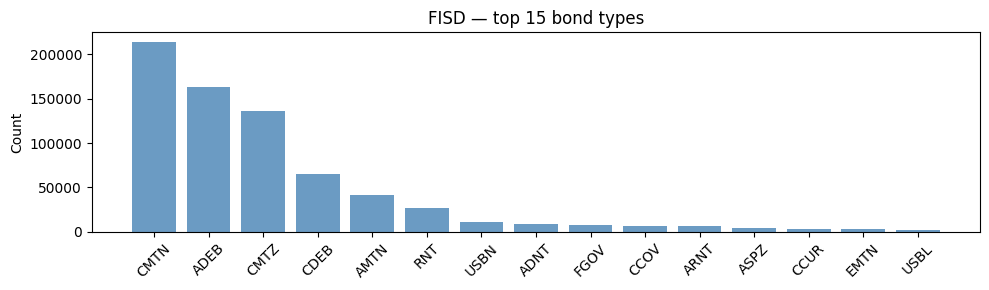

In [12]:
import matplotlib.pyplot as plt

bt = (
    fisd_issue.group_by("bond_type")
    .agg(pl.len().alias("n"))
    .sort("n", descending=True)
    .head(15)
    .collect()
)

fig, ax = plt.subplots(figsize=(10, 3))
ax.bar(bt["bond_type"].to_list(), bt["n"].to_list(), color="steelblue", alpha=0.8)
ax.set_ylabel("Count")
ax.set_title("FISD — top 15 bond types")
ax.tick_params(axis="x", rotation=45)
fig.tight_layout()
plt.show()

---
## 4. FISD Issuer Data — `pulled/fisd_issuer.parquet`

Source script: `pull_fisd.py` | WRDS table: `fisd.fisd_mergedissuer`

One row per bond issuer. Provides the country of domicile and SIC
industry classification for each issuer. Linked to the issue table
via `issuer_id`.

**Key columns:**

| Column | Description |
|---|---|
| `issuer_id` | Unique issuer identifier (joins to issue table) |
| `country_domicile` | Country of domicile (ISO code) |
| `sic_code` | Standard Industrial Classification code |

In [13]:
fisd_issuer = pl.scan_parquet(PULL_DIR / "fisd_issuer.parquet")
n_rows_issuer = fisd_issuer.select(pl.len()).collect().item()
cols_issuer = fisd_issuer.collect_schema().names()
print(f"Rows: {n_rows_issuer:,}  |  Columns: {len(cols_issuer)}")
print(f"Column names: {cols_issuer}")

Rows: 17,200  |  Columns: 3
Column names: ['issuer_id', 'country_domicile', 'sic_code']


### Example rows

In [14]:
fisd_issuer.head(5).collect()

issuer_id,country_domicile,sic_code
f64,str,str
3.0,"""USA""","""3720"""
4.0,"""NLD""","""6029"""
6.0,"""USA""",null
7.0,"""USA""","""7382"""
8.0,"""USA""",null


### Top 10 countries of domicile

In [15]:
(
    fisd_issuer.group_by("country_domicile")
    .agg(pl.len().alias("n"))
    .sort("n", descending=True)
    .head(10)
    .collect()
)

country_domicile,n
str,u32
"""USA""",11895
"""CAN""",724
null,594
"""GBR""",456
"""NLD""",284
"""CYM""",230
"""BRA""",185
"""FRA""",163
"""DEU""",154


---
## 5. FISD Ratings (Moody's) — `pulled/fisd_ratings_moodys.parquet`

Source script: `pull_fisd.py` | WRDS table: `fisd.fisd_ratings` (filtered to `rating_type = 'MR'`)

Historical Moody's credit ratings for each bond issue. One row per
rating event (initial assignment, upgrade, downgrade).

**Key columns:**

| Column | Description |
|---|---|
| `issue_id` | FISD issue identifier |
| `rating_date` | Date of the rating action |
| `rating` | Moody's rating string (e.g. Aaa, Baa1) |

In [16]:
ratings_mdy = pl.scan_parquet(PULL_DIR / "fisd_ratings_moodys.parquet")
n_rows_mdy = ratings_mdy.select(pl.len()).collect().item()
cols_mdy = ratings_mdy.collect_schema().names()
print(f"Rows: {n_rows_mdy:,}  |  Columns: {len(cols_mdy)}")
print(f"Column names: {cols_mdy}")

Rows: 1,482,164  |  Columns: 3
Column names: ['issue_id', 'rating_date', 'rating']


### Example rows

In [17]:
ratings_mdy.head(5).collect()

issue_id,rating_date,rating
f64,str,str
1.0,"""1993-05-26""","""Baa3"""
1.0,"""1997-01-23""","""Baa2"""
1.0,"""1999-12-29""","""Baa2"""
1.0,"""2000-12-15""","""Baa2"""
1.0,"""2001-04-06""","""Baa3"""


### Date range

In [18]:
ratings_mdy.select(
    pl.col("rating_date").min().alias("earliest"),
    pl.col("rating_date").max().alias("latest"),
).collect()

earliest,latest
str,str
"""1895-10-01""","""2090-10-04"""


---
## 6. FISD Ratings (S&P) — `pulled/fisd_ratings_sp.parquet`

Source script: `pull_fisd.py` | WRDS table: `fisd.fisd_ratings` (filtered to `rating_type = 'SPR'`)

Historical S&P credit ratings for each bond issue. One row per
rating event (initial assignment, upgrade, downgrade).

**Key columns:**

| Column | Description |
|---|---|
| `issue_id` | FISD issue identifier |
| `rating_date` | Date of the rating action |
| `rating` | S&P rating string (e.g. AAA, BBB+) |

In [19]:
ratings_sp = pl.scan_parquet(PULL_DIR / "fisd_ratings_sp.parquet")
n_rows_sp = ratings_sp.select(pl.len()).collect().item()
cols_sp = ratings_sp.collect_schema().names()
print(f"Rows: {n_rows_sp:,}  |  Columns: {len(cols_sp)}")
print(f"Column names: {cols_sp}")

Rows: 1,185,202  |  Columns: 3
Column names: ['issue_id', 'rating_date', 'rating']


### Example rows

In [20]:
ratings_sp.head(5).collect()

issue_id,rating_date,rating
f64,str,str
1.0,"""1995-02-22""","""BBB-"""
1.0,"""1997-02-07""","""BBB-"""
1.0,"""1997-07-03""","""BBB"""
1.0,"""2001-09-21""","""BBB"""
2.0,"""1995-02-22""","""BBB-"""


### Date range

In [21]:
ratings_sp.select(
    pl.col("rating_date").min().alias("earliest"),
    pl.col("rating_date").max().alias("latest"),
).collect()

earliest,latest
str,str
"""1895-10-01""","""2091-06-14"""


---
## 7. FISD Redemption — `pulled/fisd_redemption.parquet`

Source script: `pull_fisd.py` | WRDS table: `fisd.fisd_mergedredemption`

Callable/redeemable flags from the FISD redemption table. Indicates
whether a bond issue is callable.

**Key columns:**

| Column | Description |
|---|---|
| `issue_id` | FISD issue identifier |
| `callable` | Flag indicating whether the bond is callable |

In [22]:
redemp = pl.scan_parquet(PULL_DIR / "fisd_redemption.parquet")
n_rows_redemp = redemp.select(pl.len()).collect().item()
cols_redemp = redemp.collect_schema().names()
print(f"Rows: {n_rows_redemp:,}  |  Columns: {len(cols_redemp)}")
print(f"Column names: {cols_redemp}")

Rows: 431,041  |  Columns: 2
Column names: ['issue_id', 'callable']


### Example rows

In [23]:
redemp.head(5).collect()

issue_id,callable
f64,str
4.0,"""Y"""
5.0,"""N"""
6.0,"""N"""
8.0,"""N"""
9.0,"""N"""


---
## 8. Liu-Wu Treasury Yields — `pulled/liu_wu_yields.parquet`

Source script: `pull_liu_wu_yields.py` | Source: Liu-Wu (Google Sheets)

Zero-coupon Treasury yield curve at selected maturities, daily-resampled
with forward fill. Yields are expressed as decimals (e.g. 0.035 = 3.5%).
Used by Stage 1 to compute credit spreads.

**Key columns:**

| Column | Description |
|---|---|
| `trd_exctn_dt` | Date |
| `oneyr` | 1-year zero-coupon yield |
| `twoyr` | 2-year zero-coupon yield |
| `fiveyr` | 5-year zero-coupon yield |
| `sevyr` | 7-year zero-coupon yield |
| `tenyr` | 10-year zero-coupon yield |
| `twentyr` | 20-year zero-coupon yield |
| `thirtyr` | 30-year zero-coupon yield |

In [24]:
liu_wu = pl.scan_parquet(PULL_DIR / "liu_wu_yields.parquet")
n_rows_lw = liu_wu.select(pl.len()).collect().item()
cols_lw = liu_wu.collect_schema().names()
print(f"Rows: {n_rows_lw:,}  |  Columns: {len(cols_lw)}")
print(f"Column names: {cols_lw}")

Rows: 9,102  |  Columns: 8
Column names: ['trd_exctn_dt', 'oneyr', 'twoyr', 'fiveyr', 'sevyr', 'tenyr', 'twentyr', 'thirtyr']


### Example rows

In [25]:
liu_wu.head(5).collect()

trd_exctn_dt,oneyr,twoyr,fiveyr,sevyr,tenyr,twentyr,thirtyr
datetime[ns],f64,f64,f64,f64,f64,f64,f64
2000-01-31 00:00:00,0.062327,0.065336,0.066721,0.066368,0.066083,0.065692,0.062096
2000-02-01 00:00:00,0.062436,0.065138,0.066701,0.065991,0.06565,0.064933,0.061348
2000-02-02 00:00:00,0.062205,0.065213,0.066471,0.065698,0.065173,0.064004,0.059505
2000-02-03 00:00:00,0.061771,0.064641,0.065422,0.064795,0.064132,0.063126,0.057421
2000-02-04 00:00:00,0.062466,0.065632,0.066751,0.065878,0.065124,0.064041,0.058841


### Date range

In [26]:
liu_wu.select(
    pl.col("trd_exctn_dt").min().alias("earliest"),
    pl.col("trd_exctn_dt").max().alias("latest"),
).collect()

earliest,latest
datetime[ns],datetime[ns]
2000-01-31 00:00:00,2024-12-31 00:00:00


---
## 9. OSBAP Corporate Bond Returns — `pulled/corporate_bond_returns.parquet`

Source script: `pull_open_source_bond.py`

Monthly bond-level returns from the Open Source Bond Asset Pricing
(OSBAP) project at [openbondassetpricing.com](https://openbondassetpricing.com).
**Used only for validation**: compared against Stage 1 output in
`test_stage1_vs_open_source.py` to benchmark duration, convexity,
credit spreads, and other metrics. Not consumed by any processing stage.

**Key columns** (partial — see OSBAP documentation for full schema):

| Column | Description |
|---|---|
| `cusip` | 9-character CUSIP |
| `date` | Month-end date |
| `bond_ret` | Total bond return |
| `bond_prc` | Bond price |
| `mod_dur` | Modified duration |
| `convexity` | Convexity |
| `credit_spread` | Credit spread (OAS) |

In [27]:
corp = pl.scan_parquet(PULL_DIR / "corporate_bond_returns.parquet")
n_rows_corp = corp.select(pl.len()).collect().item()
cols_corp = corp.collect_schema().names()
print(f"Rows: {n_rows_corp:,}  |  Columns: {len(cols_corp)}")
print(f"Column names: {cols_corp}")

Rows: 1,859,546  |  Columns: 140
Column names: ['cusip', 'date', 'issuer_cusip', 'permno', 'permco', 'gvkey', '144a', 'country', 'call', 'ret_vw', 'ret_vw_bgn', 'hprd', 'lib', 'libd', 'ret_type', 'spc_rat', 'mdc_rat', 'ff17num', 'ff30num', 'fce_val', 'mcap_s', 'mcap_e', 'tret', 'rfret', 'dt_s', 'dt_e', 'dt_s_bgn', 'dt_e_bgn', 'hprd_bgn', 'igap_bgn', 'sig_dt', 'sig_gap', 'tmat', 'age', 'ytm', 'cs', 'md_dur', 'convx', 'bbtm', 'sze', 'val_hz', 'val_hz_dts', 'val_ipr', 'val_ipr_dts', 'dcs6', 'cs_mu12_1', 'pi', 'ami', 'ami_v', 'lix', 'ilq', 'roll', 'spd_abs', 'spd_rel', 'cs_sprd', 'ar_sprd', 'p_zro', 'p_fht', 'vov', 'dvol', 'dskew', 'dkurt', 'db_mkt', 'dvol_sys', 'dvol_idio', 'rvol', 'rsj', 'rsk', 'rkt', 'b_vix', 'b_dvixd', 'b_mktrf_mkt', 'b_mktb_mkt', 'ivol_mkt', 'ivol_bbw', 'b_mktbx_dcapm', 'b_term_dcapm', 'b_dvix_va', 'b_dvix_vp', 'ivol_vp', 'b_psb_m', 'b_amd_m', 'b_dvix', 'b_cpi_vol6', 'b_dunc', 'b_unc', 'b_dunc3', 'b_dunc6', 'b_duncr', 'b_duncf', 'b_dcredit', 'b_credit', 'b_dcpi', 'b_c

### Example rows

In [28]:
corp.head(5).collect()

cusip,date,issuer_cusip,permno,permco,gvkey,144a,country,call,ret_vw,ret_vw_bgn,hprd,lib,libd,ret_type,spc_rat,mdc_rat,ff17num,ff30num,fce_val,mcap_s,mcap_e,tret,rfret,dt_s,dt_e,dt_s_bgn,dt_e_bgn,hprd_bgn,igap_bgn,sig_dt,sig_gap,tmat,age,ytm,cs,md_dur,…,b_defb,b_termb,b_drf,b_crf,b_lrf,b_mktb,b_lvl,b_ysp,b_mktb_dn,b_mktb_up,b_epu,b_epum,b_eput,sysmom3_1,sysmom6_1,sysmom12_1,idimom3_1,idimom6_1,idimom12_1,mom3_1,mom6_1,mom9_1,mom12_1,mom12_7,ltr48_12,ltr30_6,ltr24_3,imom1,imom3_1,imom12_1,iltr48_12,iltr30_6,iltr24_3,var_90,es_90,var_95,str
cat,datetime[ns],cat,f64,f64,f64,i8,cat,i8,f32,f32,i16,f32,f32,cat,i32,i32,i8,i8,i64,f32,f32,f32,f64,datetime[ns],datetime[ns],datetime[ns],datetime[ns],i16,i8,datetime[ns],f64,f32,f32,f32,f32,f32,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f32
"""000336AE7""",2002-08-31 00:00:00,"""000336""",75188.0,null,null,0,"""USA""",1,0.007252,null,26,0.006879,0.006951,"""standard""",1,1,16,29,100000,98.714943,99.430847,0.015109,0.0014,2002-07-26 00:00:00,2002-08-30 00:00:00,null,null,null,null,2002-08-28 00:00:00,2.0,5.755,4.260096,0.064316,0.028395,4.636,…,0.225794,0.51265,0.188553,-0.285256,null,0.725394,-1.180318,0.223442,0.739371,0.714315,0.141684,0.062932,0.275439,-0.011314,-0.027213,-0.032832,0.027159,0.002156,0.012363,0.015825,-0.025425,-0.016064,-0.021164,-0.005107,-0.025394,-0.025394,-0.025394,0.009089,0.016714,0.070078,0.259947,0.25091,0.202824,0.032174,0.035203,0.038233,0.051041
"""000336AE7""",2002-09-30 00:00:00,"""000336""",75188.0,null,null,0,"""USA""",1,-0.05466,-0.061185,20,null,null,"""standard""",1,1,16,29,100000,99.430847,93.995956,0.026486,0.0014,2002-08-30 00:00:00,2002-09-30 00:00:00,2002-09-03 00:00:00,2002-09-30 00:00:00,19,1,2002-09-23 00:00:00,5.0,5.67,4.344969,0.075301,0.045019,4.515,…,0.469064,0.152257,0.216405,0.198128,null,0.60476,0.16412,-0.535116,0.259219,0.886356,-0.069745,-0.038121,0.147658,0.006335,-0.02346,-0.039896,0.017942,0.007689,0.036977,0.0244,-0.016358,-0.013613,-0.003806,0.014823,-0.025394,-0.026544,-0.026544,0.015736,0.024968,0.075254,0.263304,0.213676,0.196803,0.038233,0.046446,0.05466,-0.002936
"""000336AE7""",2002-10-31 00:00:00,"""000336""",75188.0,null,null,0,"""USA""",1,0.051999,null,23,0.015625,0.015362,"""standard""",1,1,16,29,100000,93.995956,98.883682,-0.002311,0.0014,2002-09-30 00:00:00,2002-10-31 00:00:00,null,null,null,null,2002-10-25 00:00:00,4.0,5.585,4.429842,0.074274,0.040876,4.429,…,0.527977,-0.007771,0.341365,0.338517,null,0.509735,-0.534577,0.386113,0.4056,0.59334,0.040134,0.002559,0.267605,0.018975,0.006474,-0.006987,-0.066383,-0.044732,-0.043342,-0.047804,-0.039212,-0.063172,-0.051381,0.020156,-0.026544,-0.009971,-0.009971,0.014274,0.030234,0.067641,0.295979,0.237394,0.20679,0.038233,0.046446,0.05466,0.066941
"""000336AE7""",2002-11-30 00:00:00,"""000336""",75188.0,null,null,0,"""USA""",1,0.080557,0.064208,21,null,null,"""standard""",1,1,16,29,100000,98.883682,103.431,-0.015273,0.0012,2002-10-31 00:00:00,2002-11-27 00:00:00,2002-11-01 00:00:00,2002-11-27 00:00:00,18,1,2002-11-26 00:00:00,1.0,5.511,4.503765,0.068748,0.035259,4.375,…,0.990068,-0.355257,0.585584,0.646973,null,0.926985,-1.150049,1.656477,0.261913,1.387602,0.121245,0.061712,0.409904,0.007409,0.030024,0.015147,-0.01007,-0.009588,-0.025985,-0.005503,0.017561,-0.023759,-0.014382,-0.024863,-0.009971,-0.009971,-0.002791,0.001263,0.015555,0.075689,0.260612,0.262213,0.207362,0.038233,0.046446,0.05466,0.04528
"""000336AE7""",2003-04-30 00:00:00,"""000336""",75188.0,null,null,0,"""USA""",1,0.067899,0.026802,21,null,null,"""standard""",1,1,16,29,100000,88.450653,94.45639,0.001701,0.001,2003-03-31 00:00:00,2003-04-29 00:00:00,2003-04-01 00:00:00,2003-04-29 00:00:00,19,1,2003-04-28 00:00:00,1.0,5.092,4.922656,0.09288,0.063154,4.019,…,1.545703,-0.747995,0.857728,1.005559,null,1.419267,-2.739921,4.100357,1.217454,1.546506,0.733772,0.203213,0.764671,0.07863,0.161576,0.188828,0.196734,0.11

### Date range

In [29]:
date_cols_corp = [c for c in cols_corp if "date" in c.lower() or "dt" in c.lower()]
if date_cols_corp:
    corp.select(
        pl.col(date_cols_corp[0]).min().alias("earliest"),
        pl.col(date_cols_corp[0]).max().alias("latest"),
    ).collect()

---
## 10. OSBAP Linker (Fang, 2025) — `pulled/osbap_linker.parquet`

Source script: `pull_open_source_bond.py` | Source: openbondassetpricing.com

**Core Stage 1 input.** Bond-firm link file constructed by Chuck Fang
(cite: Fang, 2025, "Monetary Policy Amplification through Bond Fund
Flows", working paper). Maps issuer CUSIPs to equity identifiers
(PERMNO, PERMCO, GVKEY) in real time.

Many bonds are issued through subsidiaries that do not share the
parent's identifiers (e.g. Shell plc vs Shell International Finance BV),
and 19% of CUSIP6s change ultimate parents over time. Fang constructs
the link using the CUSIP-ticker mapping from ICE and TRACE, the
ticker-GVKEY mapping from Compustat Snapshot, and the CRSP-Compustat
Link from CRSP, with extensive hand corrections.

Coverage: 93% (99%) of USD corporate debentures by amount outstanding
(trading volume), including 29,253 foreign/private issuers and 8,862
144A bonds not covered by the WRDS Bond-CRSP Link.

Used in Step 7 of `stage1_pipeline.py`: forward-filled and left-joined
on issuer CUSIP + year-month to attach equity IDs to every bond record.

In [30]:
linker = pl.scan_parquet(PULL_DIR / "osbap_linker.parquet")
n_rows_linker = linker.select(pl.len()).collect().item()
cols_linker = linker.collect_schema().names()
print(f"Rows: {n_rows_linker:,}  |  Columns: {len(cols_linker)}")
print(f"Column names: {cols_linker}")

Rows: 21,845,380  |  Columns: 5
Column names: ['ISSUER_CUSIP', 'GVKEY', 'PERMNO', 'PERMCO', 'YYYYMM']


### Example rows

In [31]:
linker.head(5).collect()

ISSUER_CUSIP,GVKEY,PERMNO,PERMCO,YYYYMM
str,f64,f64,f64,i64
"""000021""",23052.0,78736.0,29189.0,199701
"""000021""",23052.0,78736.0,29189.0,199702
"""000021""",23052.0,78736.0,29189.0,199703
"""000021""",23052.0,78736.0,29189.0,199704
"""000021""",23052.0,78736.0,29189.0,199705


---
## 11. OSBAP Treasury Bond Returns — `pulled/treasury_bond_returns.parquet`

Source script: `pull_open_source_bond.py`

Treasury bond returns from the OSBAP project. **Currently documentation
only** — not consumed by any processing or validation stage in the
pipeline.

In [32]:
treas = pl.scan_parquet(PULL_DIR / "treasury_bond_returns.parquet")
n_rows_treas = treas.select(pl.len()).collect().item()
cols_treas = treas.collect_schema().names()
print(f"Rows: {n_rows_treas:,}  |  Columns: {len(cols_treas)}")
print(f"Column names: {cols_treas}")

Rows: 2,381,340  |  Columns: 5
Column names: ['DATE', 'CUSIP', 'tr_return', 'tr_ytm_match', 'tau']


### Example rows

In [33]:
treas.head(5).collect()

DATE,CUSIP,tr_return,tr_ytm_match,tau
i64,str,f64,f64,f64
20020731,"""000325AA8""",null,null,0.545205
20020831,"""000325AA8""",0.09257,null,0.460274
20021031,"""000325AA8""",null,null,0.293151
20021130,"""000325AA8""",0.215493,null,0.210959
20021231,"""000325AA8""",0.109617,null,0.126027


### Date range

In [34]:
date_cols_treas = [c for c in cols_treas if "date" in c.lower() or "dt" in c.lower()]
if date_cols_treas:
    treas.select(
        pl.col(date_cols_treas[0]).min().alias("earliest"),
        pl.col(date_cols_treas[0]).max().alias("latest"),
    ).collect()

---
## 12. TRACE 144A — `pulled/trace_144a/`

Source script: `pull_trace_144a.py` | WRDS table: `trace.trace_btds144a`

Trade-level data for Rule 144A private placement bonds. These are
bonds sold to qualified institutional buyers under SEC Rule 144A.
Data starts July 2002. Same column schema as TRACE Standard.

**Key columns:**

| Column | Description |
|---|---|
| `cusip_id` | 9-character CUSIP bond identifier |
| `trd_exctn_dt` | Trade execution date |
| `trd_exctn_tm` | Trade execution time |
| `rptd_pr` | Reported price (per $100 par) |
| `ascii_rptd_vol_tx` | Reported volume (text field) |
| `yld_pt` | Yield at time of trade |
| `trc_st` | TRACE status |
| `side` | Trade side |
| `msg_seq_nb` | Message sequence number |

In [35]:
trace_144a_dir = PULL_DIR / "trace_144a"
trace_144a = pl.scan_parquet(
    trace_144a_dir / "**/*.parquet",
    hive_partitioning=True,
    allow_missing_columns=True,
)
n_rows_144a = trace_144a.select(pl.len()).collect().item()
cols_144a = trace_144a.collect_schema().names()
print(f"Rows: {n_rows_144a:,}  |  Columns: {len(cols_144a)}")
print(f"Column names: {cols_144a}")

Rows: 20,357,504  |  Columns: 21
Column names: ['cusip_id', 'bond_sym_id', 'bsym', 'trd_exctn_dt', 'trd_exctn_tm', 'msg_seq_nb', 'trc_st', 'wis_fl', 'cmsn_trd', 'ascii_rptd_vol_tx', 'rptd_pr', 'yld_pt', 'asof_cd', 'side', 'diss_rptg_side_cd', 'orig_msg_seq_nb', 'orig_dis_dt', 'rptg_party_type', 'contra_party_type', 'year', 'month']


/var/folders/l3/tj6vb0ld2ys1h939jz0qrfrh0000gn/T/ipykernel_72101/1672643635.py:2: DeprecationWarning: the parameter `allow_missing_columns` for `scan_parquet` is deprecated. Use the parameter `missing_columns` instead and pass one of `('insert', 'raise')`.
(Deprecated in version 1.30.0)
  trace_144a = pl.scan_parquet(


### Example rows

In [36]:
trace_144a.head(5).collect()

cusip_id,bond_sym_id,bsym,trd_exctn_dt,trd_exctn_tm,msg_seq_nb,trc_st,wis_fl,cmsn_trd,ascii_rptd_vol_tx,rptd_pr,yld_pt,asof_cd,side,diss_rptg_side_cd,orig_msg_seq_nb,orig_dis_dt,rptg_party_type,contra_party_type,year,month
str,str,str,date,time,f64,str,str,str,str,f64,f64,str,str,str,f64,date,str,str,i64,i64
"""053773BE6""","""CAR5025361""","""BBG00WGJGS47""",2003-08-03,18:13:03,3463.0,"""N""",null,null,"""1MM+""",93.0,7.041207,"""A""","""B""",null,6785.0,2020-08-06,"""D""","""C""",2003,8
"""053773BE6""","""CAR5025361""","""BBG00WGJGS47""",2003-08-03,18:13:03,6785.0,"""M""",null,null,"""1MM+""",93.0,7.041207,"""A""","""B""",null,null,null,"""D""","""C""",2003,8
"""045086AK1""","""ASWD4936471""","""BBG00RCZ3WB3""",2003-10-17,11:58:44,3303.0,"""M""",null,null,"""1MM+""",92.75,8.701616,"""A""","""S""",null,null,null,"""D""","""C""",2003,10
"""423074AS2""","""BRK4206318""","""BBG0080F6Q77""",2004-01-28,09:04:15,185.0,"""G""",null,"""N""","""1000000""",100.228125,4.839958,"""A""",null,"""B""",null,null,null,null,2004,1
"""225433AQ4""","""CS4353757""","""BBG00CNXL6V4""",2004-10-01,09:37:29,462.0,"""M""",null,"""N""","""5000000""",100.415,null,"""A""","""B""",null,null,null,"""D""","""C""",2004,10


### Date range

In [37]:
trace_144a.select(
    pl.col("trd_exctn_dt").min().alias("earliest"),
    pl.col("trd_exctn_dt").max().alias("latest"),
).collect()

earliest,latest
date,date
2003-08-03,2026-02-13


### Trades per month — TRACE 144A

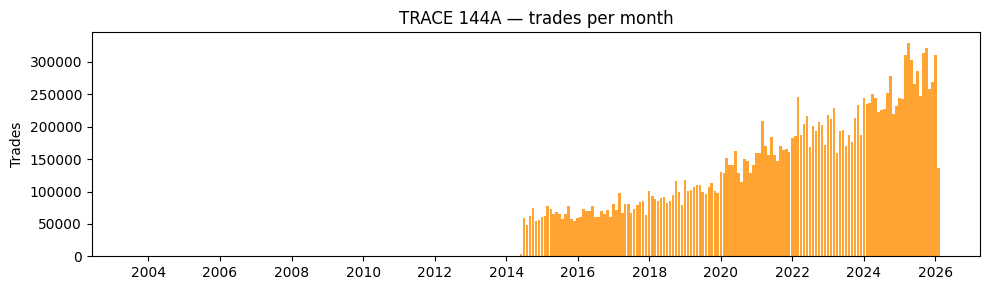

In [38]:
import matplotlib.dates as mdates

t144a_monthly = (
    trace_144a.with_columns(pl.col("trd_exctn_dt").alias("date"))
    .group_by(pl.col("date").dt.truncate("1mo"))
    .agg(pl.len().alias("n_trades"))
    .sort("date")
    .collect()
)

fig, ax = plt.subplots(figsize=(10, 3))
ax.bar(
    t144a_monthly["date"].to_list(),
    t144a_monthly["n_trades"].to_list(),
    width=25,
    color="darkorange",
    alpha=0.8,
)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.set_ylabel("Trades")
ax.set_title("TRACE 144A — trades per month")
fig.tight_layout()
plt.show()

---
## 13. TRACE Enhanced — `pulled/trace_enhanced/`

Source script: `pull_trace_enhanced.py` | WRDS table: `trace.trace_enhanced`

Trade-level corporate bond transaction data from FINRA's TRACE system
(Enhanced version). Data starts July 2002 and is stored as a
hive-partitioned data lake (`trace_enhanced/year=YYYY/month=MM/data.parquet`).
Each row is one reported trade with price, volume, and counterparty details.

**Key columns:**

| Column | Description |
|---|---|
| `cusip_id` | 9-character CUSIP bond identifier |
| `trd_exctn_dt` | Trade execution date |
| `trd_exctn_tm` | Trade execution time |
| `rptd_pr` | Reported price (per $100 par) |
| `entrd_vol_qt` | Entered volume (par value) |
| `yld_pt` | Yield at time of trade |
| `trc_st` | TRACE status (T, X, C, W, Y) |
| `msg_seq_nb` | Message sequence number |
| `rpt_side_cd` | Reporting side (B=buy, S=sell) |
| `cntra_mp_id` | Counterparty market participant ID |

In [39]:
trace_enh_dir = PULL_DIR / "trace_enhanced"
trace_enh = pl.scan_parquet(
    trace_enh_dir / "**/*.parquet",
    hive_partitioning=True,
    allow_missing_columns=True,
)
n_rows_enh = trace_enh.select(pl.len()).collect().item()
cols_enh = trace_enh.collect_schema().names()
print(f"Rows: {n_rows_enh:,}  |  Columns: {len(cols_enh)}")
print(f"Column names: {cols_enh}")

Rows: 423,792,457  |  Columns: 21
Column names: ['cusip_id', 'bond_sym_id', 'trd_exctn_dt', 'trd_exctn_tm', 'days_to_sttl_ct', 'lckd_in_ind', 'wis_fl', 'sale_cndtn_cd', 'msg_seq_nb', 'trc_st', 'trd_rpt_dt', 'trd_rpt_tm', 'entrd_vol_qt', 'rptd_pr', 'yld_pt', 'asof_cd', 'orig_msg_seq_nb', 'rpt_side_cd', 'cntra_mp_id', 'year', 'month']


/var/folders/l3/tj6vb0ld2ys1h939jz0qrfrh0000gn/T/ipykernel_72101/3951940352.py:2: DeprecationWarning: the parameter `allow_missing_columns` for `scan_parquet` is deprecated. Use the parameter `missing_columns` instead and pass one of `('insert', 'raise')`.
(Deprecated in version 1.30.0)
  trace_enh = pl.scan_parquet(


### Example rows (first partition)

In [40]:
trace_enh.head(5).collect()

cusip_id,bond_sym_id,trd_exctn_dt,trd_exctn_tm,days_to_sttl_ct,lckd_in_ind,wis_fl,sale_cndtn_cd,msg_seq_nb,trc_st,trd_rpt_dt,trd_rpt_tm,entrd_vol_qt,rptd_pr,yld_pt,asof_cd,orig_msg_seq_nb,rpt_side_cd,cntra_mp_id,year,month
str,str,date,i64,str,str,str,str,str,str,date,i64,f64,f64,f64,str,str,str,str,i64,i64
"""000325AA8""","""AAFM.GA""",2002-07-01,49893000000000,"""000""",null,"""N""","""@""","""0009218""","""T""",2002-07-01,49895000000000,1e6,118.25,17.965641,null,null,"""B""","""D""",2002,7
"""000325AA8""","""AAFM.GA""",2002-07-01,49916000000000,"""000""",null,"""N""","""@""","""0009239""","""T""",2002-07-01,49917000000000,1e6,118.25,17.965641,null,null,"""S""","""D""",2002,7
"""000325AA8""","""AAFM.GA""",2002-07-01,49916000000000,null,null,"""N""","""@""","""0009267""","""C""",2002-07-01,49917000000000,1e6,118.25,17.965641,null,"""0009239""","""S""","""D""",2002,7
"""000325AA8""","""AAFM.GA""",2002-07-01,64233000000000,"""000""",null,"""N""","""A""","""0020341""","""T""",2002-07-01,64237000000000,1e6,118.25,17.965641,null,null,"""B""","""D""",2002,7
"""000325AA8""","""AAFM.GA""",2002-07-01,64277000000000,null,null,"""N""","""A""","""0020358""","""C""",2002-07-01,64279000000000,2e6,118.25,17.965641,null,"""0020359""","""S""","""D""",2002,7


### Date range

In [41]:
trace_enh.select(
    pl.col("trd_exctn_dt").min().alias("earliest"),
    pl.col("trd_exctn_dt").max().alias("latest"),
).collect()

earliest,latest
date,date
2002-07-01,2025-03-31


### Summary statistics — price & volume

In [42]:
trace_enh.select(
    pl.col("rptd_pr").mean().alias("mean_price"),
    pl.col("rptd_pr").std().alias("std_price"),
    pl.col("rptd_pr").median().alias("median_price"),
    pl.col("entrd_vol_qt").mean().alias("mean_volume"),
    pl.col("entrd_vol_qt").median().alias("median_volume"),
).collect()

mean_price,std_price,median_price,mean_volume,median_volume
f64,f64,f64,f64,f64
97.824551,36.784462,100.0,654531.85698,25000.0


### Trades per month

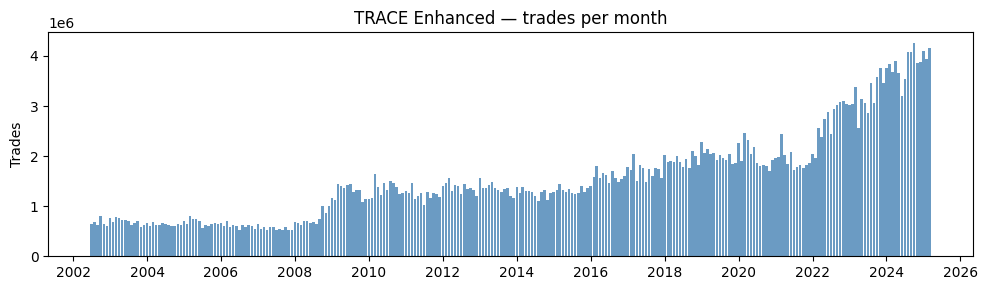

In [43]:
enh_monthly = (
    trace_enh.with_columns(pl.col("trd_exctn_dt").alias("date"))
    .group_by(pl.col("date").dt.truncate("1mo"))
    .agg(pl.len().alias("n_trades"))
    .sort("date")
    .collect()
)

fig, ax = plt.subplots(figsize=(10, 3))
ax.bar(
    enh_monthly["date"].to_list(),
    enh_monthly["n_trades"].to_list(),
    width=25,
    color="steelblue",
    alpha=0.8,
)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.set_ylabel("Trades")
ax.set_title("TRACE Enhanced — trades per month")
fig.tight_layout()
plt.show()

---
## 14. TRACE Standard — `pulled/trace_standard/`

Source script: `pull_trace_standard.py` | WRDS table: `trace.trace`

Trade-level corporate bond transaction data from the Standard TRACE feed.
Available from October 2024 onward. Same hive-partitioned storage as
Enhanced. Uses a slightly different column set (e.g. `ascii_rptd_vol_tx`
instead of `entrd_vol_qt`, `side` instead of `rpt_side_cd`).

**Key columns:**

| Column | Description |
|---|---|
| `cusip_id` | 9-character CUSIP bond identifier |
| `trd_exctn_dt` | Trade execution date |
| `trd_exctn_tm` | Trade execution time |
| `rptd_pr` | Reported price (per $100 par) |
| `ascii_rptd_vol_tx` | Reported volume (text field) |
| `yld_pt` | Yield at time of trade |
| `trc_st` | TRACE status |
| `side` | Trade side |
| `msg_seq_nb` | Message sequence number |

In [44]:
trace_std_dir = PULL_DIR / "trace_standard"
trace_std = pl.scan_parquet(
    trace_std_dir / "**/*.parquet",
    hive_partitioning=True,
    allow_missing_columns=True,
)
n_rows_std = trace_std.select(pl.len()).collect().item()
cols_std = trace_std.collect_schema().names()
print(f"Rows: {n_rows_std:,}  |  Columns: {len(cols_std)}")
print(f"Column names: {cols_std}")

Rows: 47,256,465  |  Columns: 21
Column names: ['cusip_id', 'bond_sym_id', 'bsym', 'trd_exctn_dt', 'trd_exctn_tm', 'msg_seq_nb', 'trc_st', 'wis_fl', 'cmsn_trd', 'ascii_rptd_vol_tx', 'rptd_pr', 'yld_pt', 'asof_cd', 'side', 'diss_rptg_side_cd', 'orig_msg_seq_nb', 'orig_dis_dt', 'rptg_party_type', 'contra_party_type', 'year', 'month']


/var/folders/l3/tj6vb0ld2ys1h939jz0qrfrh0000gn/T/ipykernel_72101/3284768942.py:2: DeprecationWarning: the parameter `allow_missing_columns` for `scan_parquet` is deprecated. Use the parameter `missing_columns` instead and pass one of `('insert', 'raise')`.
(Deprecated in version 1.30.0)
  trace_std = pl.scan_parquet(


### Example rows

In [45]:
trace_std.head(5).collect()

cusip_id,bond_sym_id,bsym,trd_exctn_dt,trd_exctn_tm,msg_seq_nb,trc_st,wis_fl,cmsn_trd,ascii_rptd_vol_tx,rptd_pr,yld_pt,asof_cd,side,diss_rptg_side_cd,orig_msg_seq_nb,orig_dis_dt,rptg_party_type,contra_party_type,year,month
str,str,str,date,i64,f64,str,str,str,str,f64,f64,str,str,str,f64,date,str,str,i64,i64
"""02209SBD4""","""MO4797929""","""BBG00NB2Z4S5""",2024-01-01,78261000000000,327.0,"""M""",null,null,"""3000""",100.049,4.787982,"""A""","""S""",null,null,null,"""D""","""D""",2024,1
"""254687FS0""","""DIS4969022""","""BBG00SMMG454""",2024-01-01,81521000000000,322.0,"""M""",null,null,"""5000""",97.448,4.872966,"""A""","""S""",null,null,null,"""D""","""D""",2024,1
"""30303M8J4""","""FB5522214""","""BBG01BV23038""",2024-01-01,81331000000000,330.0,"""M""",null,null,"""10000""",92.531,4.940009,"""A""","""S""",null,null,null,"""D""","""D""",2024,1
"""404280DH9""","""HBC5458071""","""BBG0192W27G1""",2024-01-01,81225000000000,26.0,"""M""",null,null,"""2000000""",101.0,null,"""A""","""S""",null,null,null,"""D""","""A""",2024,1
"""458140BX7""","""INTC5238071""","""BBG01236J676""",2024-01-01,81367000000000,337.0,"""M""",null,null,"""10000""",69.707,4.993,"""A""","""S""",null,null,null,"""D""","""D""",2024,1


### Date range

In [46]:
trace_std.select(
    pl.col("trd_exctn_dt").min().alias("earliest"),
    pl.col("trd_exctn_dt").max().alias("latest"),
).collect()

earliest,latest
date,date
2024-01-01,2026-02-13
